In [16]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [17]:
df = pd.read_csv('combined_data.csv')
df.head()

,Date,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1


In [23]:
# Resampling to daily frequency
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None) 
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

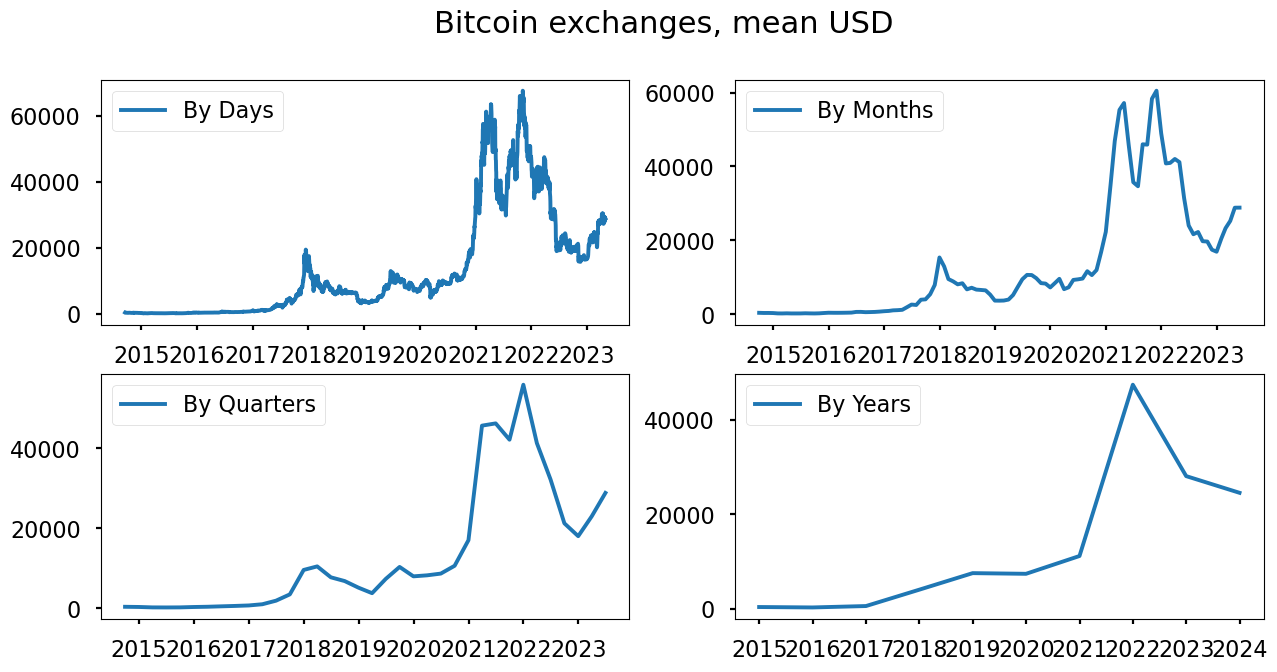

In [24]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.tomorrow, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.tomorrow, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.tomorrow, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.tomorrow, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.507713


<Figure size 1500x700 with 0 Axes>

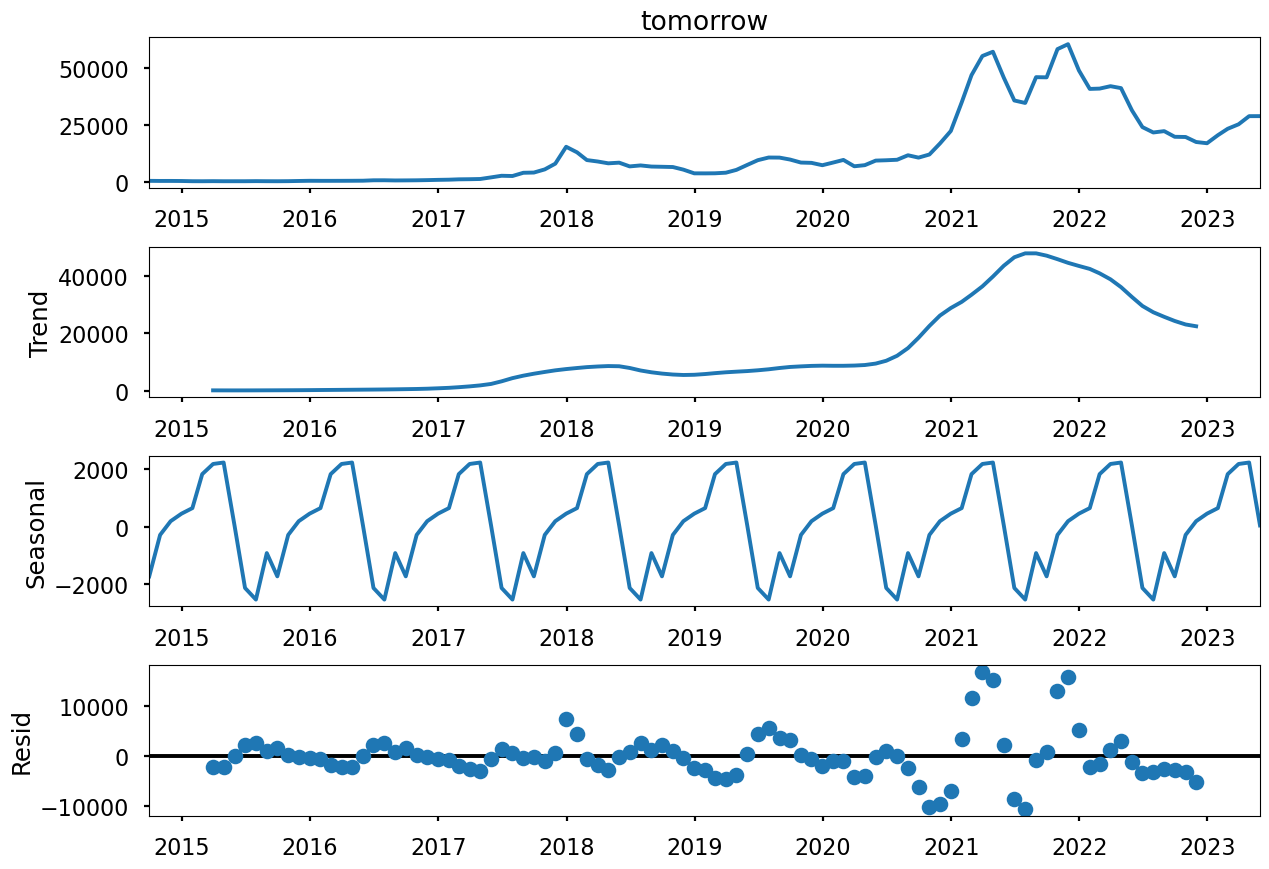

In [25]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.tomorrow).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.tomorrow)[1])
plt.show()

In [28]:
df_month['Tomorrow_Price_box'], lmbda = stats.boxcox(df_month.tomorrow)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.tomorrow)[1])

Dickey–Fuller test: p=0.507713


In [29]:
df_month['prices_box_diff'] = df_month.Tomorrow_Price_box - df_month.Tomorrow_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.374962


Dickey–Fuller test: p=0.000291


<Figure size 1500x700 with 0 Axes>

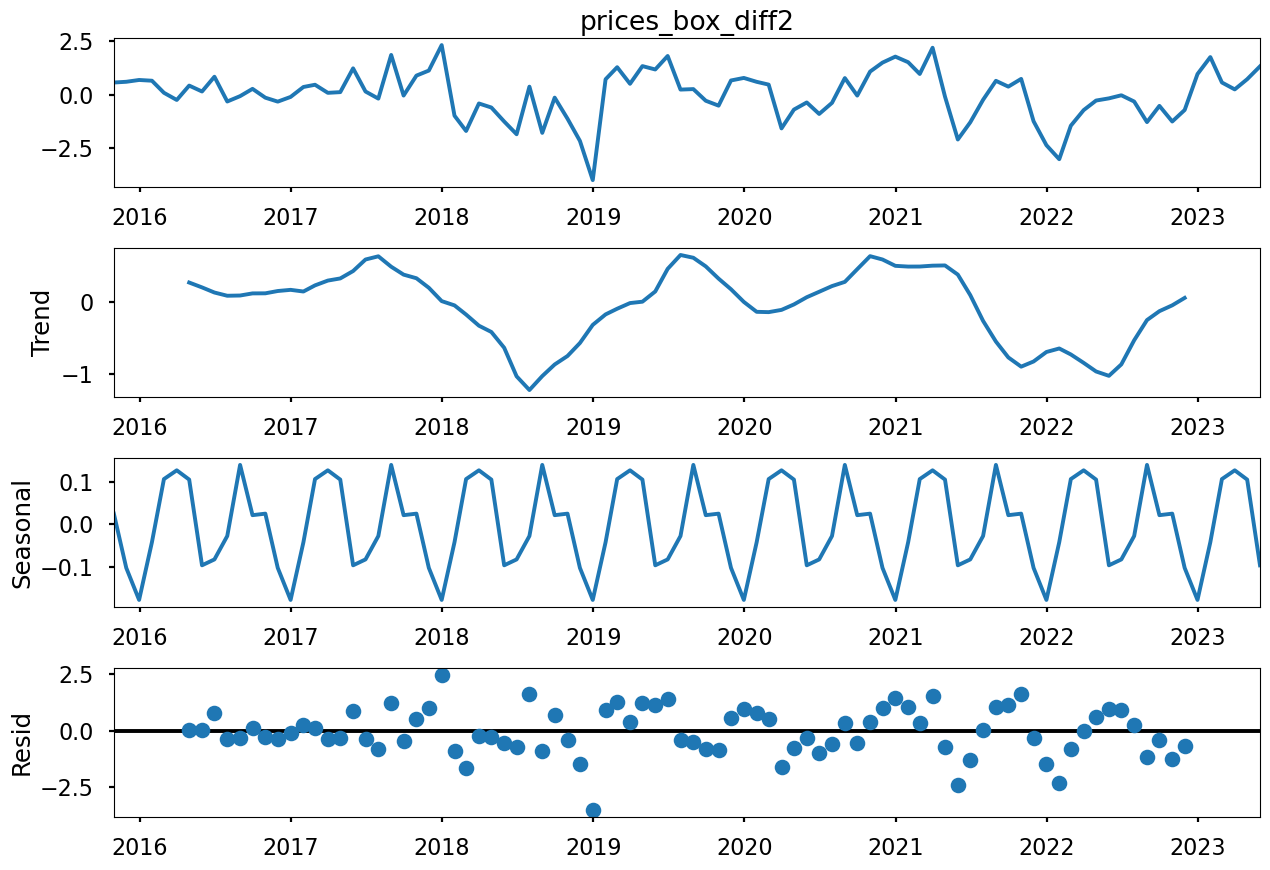

In [30]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

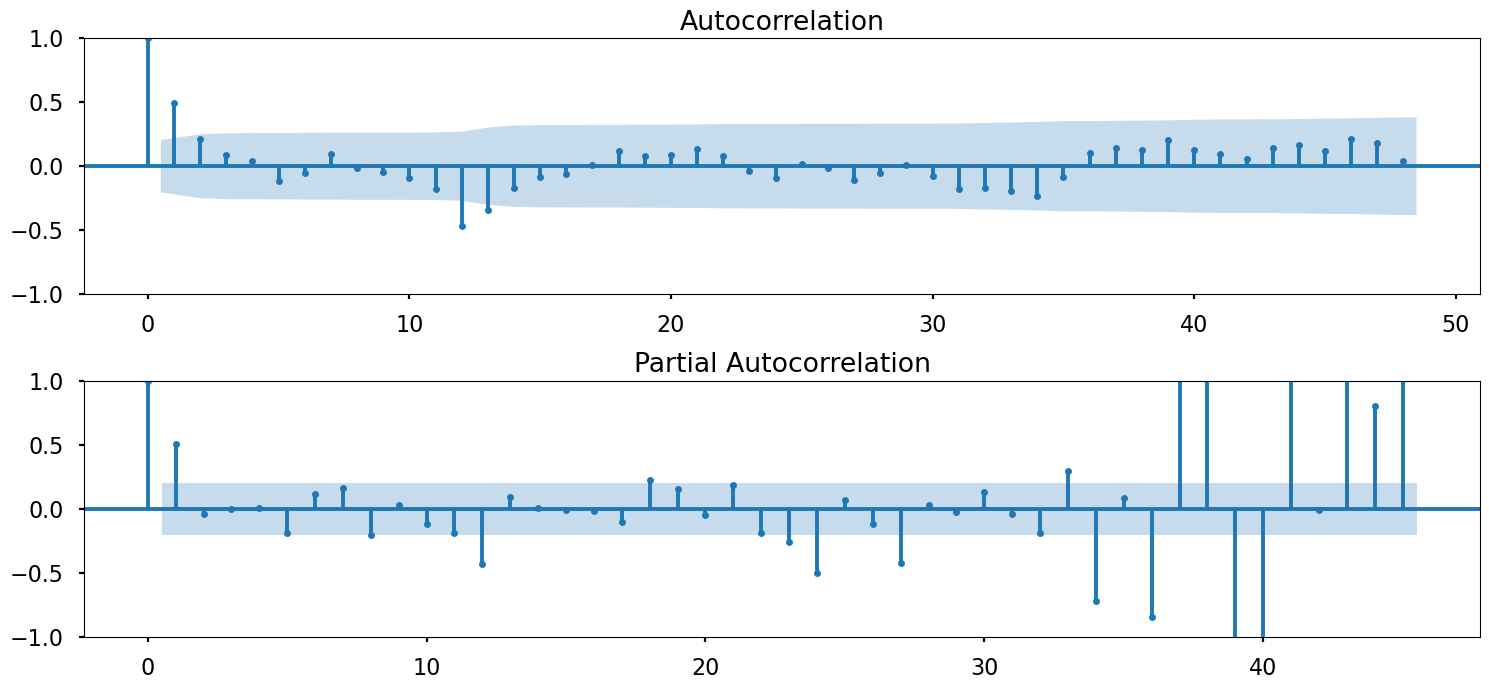

In [52]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

In [51]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [36]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  223.656583
23  (1, 0, 2, 1)  224.936110
7   (0, 1, 0, 1)  224.979169
25  (1, 1, 0, 1)  225.111183
37  (2, 0, 0, 1)  225.122503
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  105
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -108.828
Date:                              Sat, 06 May 2023   AIC                            223.657
Time:                                      00:09:20   BIC                            231.222
Sample:                                  09-30-2014   HQIC                           226.710
                                       - 05-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


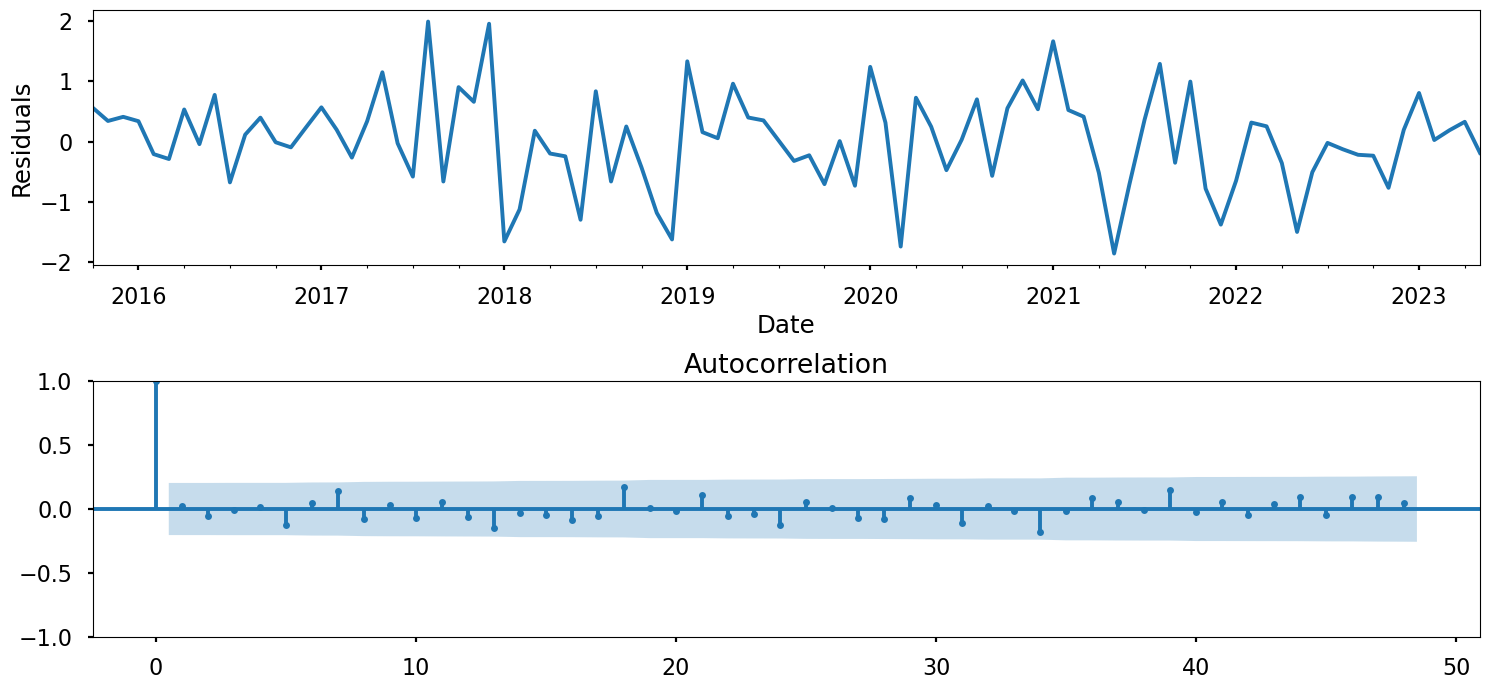

In [37]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [38]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))